In [ ]:
# creates 
#  - connectivity table for paper - SupplTable-S5-connectivity-stats.xls
#  - DotPlot of connections - SupplFigure-S5-source-target-interactions.png
#  - known melanoma driver gene ranking in networks - SupplTable-S6-key-driver-ranks.xls

In [71]:
library(ggplot2)
library(gridExtra)
library(parallel)
library(xlsx)
library(pheatmap)

In [82]:
basePath = "/data/bcu_projects/MelBrainSys_PostdocProject_Gruetzmann/publications/2022-my-MelBrainSys-paper/scripts-etc-for-publication/"
myPath = paste0(basePath,"regNet/")

In [83]:
localRlibs = paste0(basePath,"conda/lib/R/library/")
library(regNet)

In [84]:
setwd(myPath)

In [85]:
outDirectory = paste0(basePath,"FiguresTables/")

In [12]:
output=T
projectName = "MyNetwork-1"
networkName = "TcgaMelanomaExprMeth"
numOfNWs = 2

In [29]:
myPath

[1] "/data/bcu_projects/MelBrainSys_PostdocProject_Gruetzmann/publications/2022-my-MelBrainSys-paper/scripts-etc-for-publication/regNet/"

### create connectivity tables

In [35]:
localGeneCutoff = 30
pValCutoff = 0.001
nbCPUs = 10 

startt = Sys.time()
for(nwSubdir in paste0("TrainNetwork-",1:numOfNWs)) {
    path = paste0(myPath, nwSubdir)
    message("calculating for ",nwSubdir)
    getNetworkConnections( networkName = networkName, pValCutoff = nwSubdir,
                                 localGeneCutoff = localGeneCutoff, path = path )
}
endt = Sys.time()
endt-startt # 5 min for 2 networks

calculating for TrainNetwork-1



[1] "Load network"
[1] "Remove local predictors"
[1] "Determine gene-specific network connections"
[1] "Save network connections:"
[1] "/data/bcu_projects/MelBrainSys_PostdocProject_Gruetzmann/publications/2022-my-MelBrainSys-paper/scripts-etc-for-publication/regNet/TrainNetwork-1/NetworkConnectivity/TcgaMelanomaExprMeth_GeneSpecificNetworkConnections_PValueCutoff_TrainNetwork-1_LocalGeneCutoff_30.txt"


calculating for TrainNetwork-2



[1] "Load network"
[1] "Remove local predictors"
[1] "Determine gene-specific network connections"
[1] "Save network connections:"
[1] "/data/bcu_projects/MelBrainSys_PostdocProject_Gruetzmann/publications/2022-my-MelBrainSys-paper/scripts-etc-for-publication/regNet/TrainNetwork-2/NetworkConnectivity/TcgaMelanomaExprMeth_GeneSpecificNetworkConnections_PValueCutoff_TrainNetwork-2_LocalGeneCutoff_30.txt"


Time difference of 5.037326 mins

### statistics about connectivity

In [39]:
connectFiles = paste0("TrainNetwork-",1:numOfNWs,
                      "/NetworkConnectivity/",networkName,"_GeneSpecificNetworkConnections_PValueCutoff_",pValCutoff,
                      "_LocalGeneCutoff_30.txt")
all(file.exists(connectFiles))

[1] TRUE

In [45]:
connectStats = data.frame()
for( f in connectFiles) {
    conn = read.csv(file = f, header = T,sep = "\t",stringsAsFactors = F)
    connectStats = 
        rbind(connectStats, 
              data.frame(inRep = sum(conn$IncomingRepressorLinks), 
                         outRep = sum(conn$OutgoingRepressorLinks),
                         inAct = sum(conn$IncomingActivatorLinks), 
                         ourAct = sum(conn$OutgoingActivatorLinks),
                         inLinks = sum(conn$IncomingLinks), 
                         outLinks = sum(conn$OutgoingLinks)))
}

In [46]:
head(connectStats,3)
round(apply(connectStats,2,mean))
sum(round(apply(connectStats,2,mean))[c(1,3)]) # sum incoming
sum(round(apply(connectStats,2,mean))[c(2,4)]) # sum outgoing
round(mean(apply(connectStats[c(2,4)],1,sum))) # mean of sum of outgoing
round(sd (apply(connectStats[,c(2,4)],1,sum))) # s.d. of sum of outgoing
round(mean(connectStats[,2]/connectStats[,4]*100)) # mean ratio of outgoing repr. vs. act
round(sd(connectStats[,2]/connectStats[,4]*100)) # s.d. ratio of outgoing repr. vs. act

,inRep,outRep,inAct,ourAct,inLinks,outLinks
,<int>,<int>,<int>,<int>,<int>,<int>
1,7651,7002,25223,25212,32874,32214
2,7934,7354,26108,26093,34042,33447


inRep   outRep    inAct   ourAct  inLinks outLinks 
    7792     7178    25666    25652    33458    32830

[1] 33458

[1] 32830

[1] 32830

[1] 872

[1] 28

[1] 0

In [47]:
all(connectStats$inLinks > connectStats$outLinks)
# there are more inbound than outbound links

[1] TRUE

In [51]:
# for inLinks the promoter methylation is counted extra, while for outLinks not
conn = read.csv(file = connectFiles[1], header = T,sep = "\t",stringsAsFactors = F)
head(conn,2)
length(grep("GeneSpecificCopyNumber",conn$IncomingRepressorLinkGenes))
length(grep("GeneSpecificCopyNumber",conn$IncomingActivatorLinkGenes))
length(grep("GeneSpecificCopyNumber",conn$OutgoingRepressorLinkGenes))
length(grep("GeneSpecificCopyNumber",conn$OutgoingActivatorLinkGenes))
# only incomming links marked with methylation ("copynumber" in the original regNet paper)

,Gene,IncomingRepressorLinks,IncomingActivatorLinks,IncomingLinks,OutgoingRepressorLinks,OutgoingActivatorLinks,OutgoingLinks,IncomingRepressorLinkGenes,IncomingActivatorLinkGenes,OutgoingRepressorLinkGenes,OutgoingActivatorLinkGenes
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>
1,NOC2L,1,3,4,0,8,8,NHLRC3,ENO1;TMEM69;RRP12,,DNAJC11;SRM;MRTO4;NUDC;DPH2;TMEM69;RRP12;NOL6
2,KLHL17,0,1,1,1,5,6,,CCDC130,SIN3A,RNF207;ATXN7L2;PRR14;KIAA0895L;FRS3


[1] 649

[1] 11

[1] 0

[1] 0

In [52]:
promMethPerNW = NULL
for (f in connectFiles) {
    conn = read.csv(file = f, header = T,sep = "\t",stringsAsFactors = F)
    promMethPerNW = c(promMethPerNW,
                      length(grep("GeneSpecificCopyNumber",conn$IncomingRepressorLinkGenes)) + 
                      length(grep("GeneSpecificCopyNumber",conn$IncomingActivatorLinkGenes)))
}

In [54]:
promMethPerNW
round(mean(promMethPerNW)); round(sd(promMethPerNW))
length(promMethPerNW)
connectStats
all(connectStats$inLinks == connectStats$outLinks + promMethPerNW)
# incoming links are as many more as there are promoter methyl. links

[1] 660 595

[1] 628

[1] 46

[1] 2

inRep,outRep,inAct,ourAct,inLinks,outLinks
<int>,<int>,<int>,<int>,<int>,<int>
7651,7002,25223,25212,32874,32214
7934,7354,26108,26093,34042,33447


[1] TRUE

In [61]:
# for each gene and each of the 25 NWs, how many outgoing links
outgoingLinksPerNW = NULL
for( f in connectFiles) {
    tmp = read.csv(file = f, header = T,sep = "\t",stringsAsFactors = F)
    if(is.null(outgoingLinksPerNW)) { 
        outgoingLinksPerNW = matrix(data = tmp$OutgoingLinks, ncol = 1)
        rownames(outgoingLinksPerNW) = tmp$Gene
    } else {
        rownames(tmp) = tmp$Gene
        outgoingLinksPerNW = cbind(outgoingLinksPerNW,tmp[ rownames(outgoingLinksPerNW),"OutgoingLinks"])
    }
}

In [64]:
head(outgoingLinksPerNW)
outgoingLinksMedian = apply(outgoingLinksPerNW,1,median)
outgoingLinksMean = apply(outgoingLinksPerNW,1,mean)
outgoingLinksSD = apply(outgoingLinksPerNW,1,sd)
head(outgoingLinksMedian)
head(outgoingLinksMean)
head(outgoingLinksSD)
quantile(outgoingLinksMean, 0:20/20)

NOC2L,8,8
KLHL17,6,7
HES4,3,3
ISG15,8,10
AGRN,3,5
C1orf159,5,4


NOC2L   KLHL17     HES4    ISG15     AGRN C1orf159 
     8.0      6.5      3.0      9.0      4.0      4.5

NOC2L   KLHL17     HES4    ISG15     AGRN C1orf159 
     8.0      6.5      3.0      9.0      4.0      4.5

NOC2L    KLHL17      HES4     ISG15      AGRN  C1orf159 
0.0000000 0.7071068 0.0000000 1.4142136 1.4142136 0.7071068

0%   5%  10%  15%  20%  25%  30%  35%  40%  45%  50%  55%  60%  65%  70%  75% 
 0.0  1.0  1.5  2.0  2.0  2.5  2.5  3.0  3.0  3.5  3.5  4.0  4.0  4.5  5.0  5.0 
 80%  85%  90%  95% 100% 
 5.5  6.0  7.0  8.0 18.0

## known major regulators among top genes in our NW - SupplTable-S6-key-driver-ranks.xls
https://www.nature.com/articles/s41388-020-01490-x  presents "key drivers of transcriptional alterations of mRNA expression in melanoma"; transcription factors, co-activators, and chromatin regulators; they do melanoma initiation, progression or are driver genes
MITF, TP53, CREB, MYC, cFOS, SOX10, BRN2, DNMT3A, DNMT3B, TET1, TET2, EHMT2, IDH1, ARID2, CTCF, TERT, SDHD

ATF3 is Master Regulator in Metabolic Homeostasis and Cancer https://www.frontiersin.org/articles/10.3389/fendo.2020.00556/full

other important genes BRAF1, NRAS, KIT, NF1

In [56]:
genesAndAliasesForPaper = list(
    "KIT" = c("SCFR","CD117","C-Kit","P145","MASTC"),
    "BRAF" = c("BRAF1", "BRAF-1","RAFB1","B-RAF1","B-Raf","NS7","P94"), 
    "NRAS" = c("N-Ras","ALPS4","NRAS1","HRAS1","CMNS","NCMS","NS6"), 
    #"KRAS" = c("KRAS","C-Ki-Ras2","C-K-RAS","K-RAS2A","K-RAS2B","K-RAS4A","K-RAS4B","C-K-Ras","KI-RAS","K-Ras","CFC2","RALD","NS3","OES","NS"), 
    "NF1" = c("NFNS","VRNF","WSS"), 
    "TP53" = c("P53","LFS1","BMFS5","TRP53","BCC7"), 
    "DNMT3A" = c("DNMT3A2","HESJAS","TBRS"), 
    "DNMT3B" = c("FSHD4","ICF1","ICF"), 
    "TET1" = c("BA119F7.1","KIAA1676","CXXC6"), 
    "IDH1" = c("PICD","IDH","IDCD","IDPC","IDP"), 
    "ARID2" = c("BAF200","KIAA1557","SMARCF3","FLJ30619","CSS6","P200"), 
    "CTCF" = c("CFAP108","FAP108","MRD21"), 
    "CDKN2A" = c("P14ARF","CDK4I","MTS1","ARF","MTS1","CDKN2","CMM2","INK4","P16","P19","P16INK4a","MLM","P19Arf","INK4a","TP16"), 
    "PTEN" = c("MMAC1","TEP1","PTEN1","MHAM","BZS","PTENepsilon","PTENbeta","CWS1","GLM2","DEC"), 
    "ATF3" = c("GC01P211461","GC01P208625"),
    "MITF"=c("BHLHe32","WS2A","BHLHE32","WS2","COMMAD","MITF-A","CMM8"),
    "CREB" = c("CREB1","CREB-1"),
    "MYC" = c("BHLHe39","C-Myc","MYCC","BHLHE39","MRTL"),
    "FOS" = c("cFOS","AP-1","C-Fos","P55","G0S7"),
    "SOX10" = c("WS2E","DOM","WS4","PCWH","WS4C","SOX-10","SRY-Box 10","SRY"),
    "BRN2" = c("POU3F2","OCT7","POUF3","OTF7","OTF-7","Brain-2","Brn-2","Oct-7","N-Oct3"),
    "TET2" = c("KIAA1546","MDS","IMD75","FLJ20032"),
    "EHMT2" = c("KMT1C","G9A","C6orf30","BAT8","NG36","G9a","NG36/G9a","GAT8"),
    "TERT" = c("HEST2","TCS1","EST2","TRT","TP2","PFBMFT1","DKCA2","DKCB4","CMM9","HTRT"),
    "SDHD" = c("CybS","CII-4","PGL1","QPs3","SDH4","PGL","MC2DN3","CBT1","CWS3"))

In [65]:
g = names(genesAndAliasesForPaper)[1]
g
aliases = c(g,genesAndAliasesForPaper[[g]])
aliases
wh = which(toupper(aliases) %in% toupper(names(outgoingLinksMean)))
wh

[1] "KIT"

[1] "KIT"   "SCFR"  "CD117" "C-Kit" "P145"  "MASTC"

integer(0)

In [69]:
outDF = NULL
for(g in names(genesAndAliasesForPaper)) {
    aliases = c(g,genesAndAliasesForPaper[[g]])
    wh = which(toupper(aliases) %in% toupper(names(outgoingLinksMean)))
    if(length(wh)>0) {
        
        # find average percentile of the gene's number of outgoing links via ecdf() function
        mean_percentile = mean(
            sapply(1:ncol(outgoingLinksPerNW), function(i) {
                n = outgoingLinksPerNW[aliases[wh[1]],i]
                100*ecdf(x = outgoingLinksPerNW[,i])(n)
            })
        )

        outDF = rbind(outDF,
                      data.frame(stringsAsFactors = F,gene=g, aliases=paste0(aliases[-1],collapse=","), 
                        mean_outgoing_links = outgoingLinksMean[aliases[wh[1]]], 
                                 sd_outgoing_links = outgoingLinksSD[aliases[wh[1]]], 
                                mean_percentile_outgoing_links = mean_percentile))
    } else {
        outDF = rbind(outDF,data.frame(stringsAsFactors = F,gene=g, 
               aliases=paste0(aliases[-1],collapse=","), mean_outgoing_links=NA, sd_outgoing_links=NA, 
                                mean_percentile_outgoing_links = NA))
    }
}

In [70]:
rownames(outDF) = outDF$gene
outDF = outDF[ order(-outDF$mean_percentile_outgoing_links,outDF$gene),]
outDF

,gene,aliases,mean_outgoing_links,sd_outgoing_links,mean_percentile_outgoing_links
,<chr>,<chr>,<dbl>,<dbl>,<dbl>
ATF3,ATF3,"GC01P211461,GC01P208625",9.0,2.8284271,95.01879
DNMT3B,DNMT3B,"FSHD4,ICF1,ICF",7.0,1.4142136,89.37099
ARID2,ARID2,"BAF200,KIAA1557,SMARCF3,FLJ30619,CSS6,P200",6.0,1.4142136,83.63835
TET1,TET1,"BA119F7.1,KIAA1676,CXXC6",6.5,3.5355339,80.92352
BRAF,BRAF,"BRAF1,BRAF-1,RAFB1,B-RAF1,B-Raf,NS7,P94",6.0,2.8284271,78.63289
CTCF,CTCF,"CFAP108,FAP108,MRD21",5.5,2.1213203,77.77845
CREB,CREB,"CREB1,CREB-1",4.5,2.1213203,66.94946
FOS,FOS,"cFOS,AP-1,C-Fos,P55,G0S7",3.5,0.7071068,56.21137
DNMT3A,DNMT3A,"DNMT3A2,HESJAS,TBRS",3.5,2.1213203,53.90256


In [86]:
write.xlsx(outDF, file = paste0(outDirectory,"SupplTable-S6-key-driver-ranks.xls"))

## DotPlot of connections  - SupplFigure-S5-source-target-interactions.png

In [88]:
conn = read.csv(file = connectFiles[1], header = T,sep = "\t",stringsAsFactors = F)
activatorConn = matrix(data=0,nrow=nrow(conn),ncol=nrow(conn),
                       dimnames = c(list(conn$Gene),list(conn$Gene)))
repressorConn = activatorConn
fileCount=0
for(f in connectFiles) {
    fileCount = fileCount + 1
    message(fileCount," of ",length(connectFiles))
    conn = read.csv(file = f, header = T,sep = "\t",stringsAsFactors = F)
    for(i in 1:nrow(conn)) {
        #if(i %% 1000 == 0) { message("   line ",i," of ",nrow(conn))}
        sourceGene = conn$Gene[i]
        targetRepressedGenes = unlist(strsplit(conn$OutgoingRepressorLinkGenes[i],";"))
        targetActivatedGenes = unlist(strsplit(conn$OutgoingActivatorLinkGenes[i],";"))
        if(length(targetRepressedGenes)>0) {
            repressorConn[sourceGene,targetRepressedGenes] = repressorConn[sourceGene,targetRepressedGenes] + 1
        }
        if(length(targetActivatedGenes)>0) {
            activatorConn[sourceGene,targetActivatedGenes] = activatorConn[sourceGene,targetActivatedGenes] + 1
        }
    }
}
# 1-2 min

1 of 2

2 of 2



In [89]:
# connections in > 50% of NWs:
activatorConnBinary = ifelse(activatorConn>length(connectFiles)/2,1,0)
repressorConnBinary = ifelse(repressorConn>length(connectFiles)/2,1,0)

In [90]:
sum(activatorConnBinary) # number of consistent activators, 8658
sum(activatorConn)
sum(repressorConnBinary) # number of consistent repressors, 477
sum(repressorConn)

[1] 7573

[1] 51305

[1] 771

[1] 14356

In [92]:
# convert to long format for plotting:

connectionsActive = NULL 
for(i in 1:nrow(activatorConnBinary)){
    wh = which(activatorConnBinary[i,]>0)
    if(length(wh)>=1) {
        connectionsActive =  
            c(connectionsActive,list(
                data.frame(stringsAsFactors = F, source = rownames(activatorConnBinary)[i], 
                             target=colnames(activatorConnBinary)[wh], type="activator")))
    }
}
length(connectionsActive)
connections = do.call(rbind,connectionsActive)

[1] 4259

In [93]:
connectionsRepr = NULL 
for(i in 1:nrow(repressorConnBinary)){
    wh = which(repressorConnBinary[i,]>0)
    if(length(wh)>=1) {
        connectionsRepr =  
            c(connectionsRepr,list(
                data.frame(stringsAsFactors = F, source = rownames(repressorConnBinary)[i], 
                             target=colnames(repressorConnBinary)[wh], type="repressor")))
    }
}
length(connectionsRepr)
connections = rbind(connections,do.call(rbind,connectionsRepr))

[1] 704

In [94]:
head(connections,100)

,source,target,type
,<chr>,<chr>,<chr>
1,NOC2L,NUDC,activator
2,NOC2L,DPH2,activator
3,NOC2L,RRP12,activator
4,NOC2L,NOL6,activator
5,KLHL17,RNF207,activator
6,KLHL17,ATXN7L2,activator
7,HES4,RPP25,activator
8,ISG15,IFI6,activator
9,ISG15,IFITM1,activator


### sort geneAnnot by chr and pos

In [96]:
# gene annotation from expression file
geneAnnot = read.csv(file = "Data/MelBrainSys-expression.csv", header = T,sep = "\t",stringsAsFactors = F)
geneAnnot = geneAnnot[,1:3]
rownames(geneAnnot) = geneAnnot$geneSymbol
head(geneAnnot,3)
unique(geneAnnot$chr)

,geneSymbol,chr,pos
,<chr>,<chr>,<int>
NOC2L,NOC2L,chr1,887127
KLHL17,KLHL17,chr1,898531
HES4,HES4,chr1,934947


[1] "chr1"  "chr10" "chr11" "chr12" "chr13" "chr14" "chr15" "chr16" "chr17"
[10] "chr18" "chr19" "chr2"  "chr20" "chr21" "chr22" "chr3"  "chr4"  "chr5" 
[19] "chr6"  "chr7"  "chr8"  "chr9"  "chrX"  "chrY"

In [107]:
# sort annotation by chromosomes:
o = order(as.numeric(gsub("chr","",geneAnnot$chr)), geneAnnot$pos)
geneAnnot = geneAnnot[o,]
unique(geneAnnot$chr)
# move chrY last
wh = which(geneAnnot$chr == "chrY")
geneAnnot = geneAnnot[ c(1:(min(wh)-1),(max(wh)+1):nrow(geneAnnot),wh),]
unique(geneAnnot$chr)

Warning message in order(as.numeric(gsub("chr", "", geneAnnot$chr)), geneAnnot$pos):
“NAs introduced by coercion”


[1] "chr1"  "chr2"  "chr3"  "chr4"  "chr5"  "chr6"  "chr7"  "chr8"  "chr9" 
[10] "chr10" "chr11" "chr12" "chr13" "chr14" "chr15" "chr16" "chr17" "chr18"
[19] "chr19" "chr20" "chr21" "chr22" "chrY"  "chrX"

[1] "chr1"  "chr2"  "chr3"  "chr4"  "chr5"  "chr6"  "chr7"  "chr8"  "chr9" 
[10] "chr10" "chr11" "chr12" "chr13" "chr14" "chr15" "chr16" "chr17" "chr18"
[19] "chr19" "chr20" "chr21" "chr22" "chrX"  "chrY"

In [109]:
# get 1 number for each gene, so we can plot them normally
genesNum = 1:nrow(geneAnnot)
names(genesNum) = geneAnnot$geneSymbol
head(genesNum[ geneAnnot$geneSymbol[1:10]])
head(as.numeric(genesNum))

NOC2L   KLHL17     HES4    ISG15     AGRN C1orf159 
       1        2        3        4        5        6

[1] 1 2 3 4 5 6

In [98]:
typeCol = c("activator"="red", "repressor"="blue")

In [110]:
chrBorders = c(0,sapply(unique(geneAnnot$chr),function(chr) max(which(geneAnnot$chr == chr)))+0.5)
chrMiddles = sapply(unique(geneAnnot$chr),function(chr) mean(range(which(geneAnnot$chr == chr))))

In [111]:
plotInteractions = function() {
    par(mar=c(4,4,1,1)) # slim border
    # empty plot to get the limit right:
    plot(NA, xlim=c(1,nrow(geneAnnot)), ylim=c(1,nrow(geneAnnot)),
         xlab = "source genes", ylab  = "target genes", xaxt='n', yaxt='n')
    # rectangles for chromosomes:
    for(i in 1:(length(chrBorders-1))) {
        rect(xleft = chrBorders[i], ybottom = chrBorders[i], xright = chrBorders[i+1], ytop = chrBorders[i+1])
    }
    # points for interactions;
    points(x = genesNum[connections$source], y = genesNum[ connections$target],
         bg = typeCol[connections$type], pch=22, col=NA,cex=0.3)
    axis(side = 1,at = chrBorders, labels=F, tick = T)
    axis(side = 1,at = chrMiddles, labels = gsub("chr","",unique(geneAnnot$chr)), tick = F)
    axis(side = 2,at = chrBorders, labels=F)
    axis(side = 2,at = chrMiddles, labels = gsub("chr","",unique(geneAnnot$chr)), tick = F)
    
}

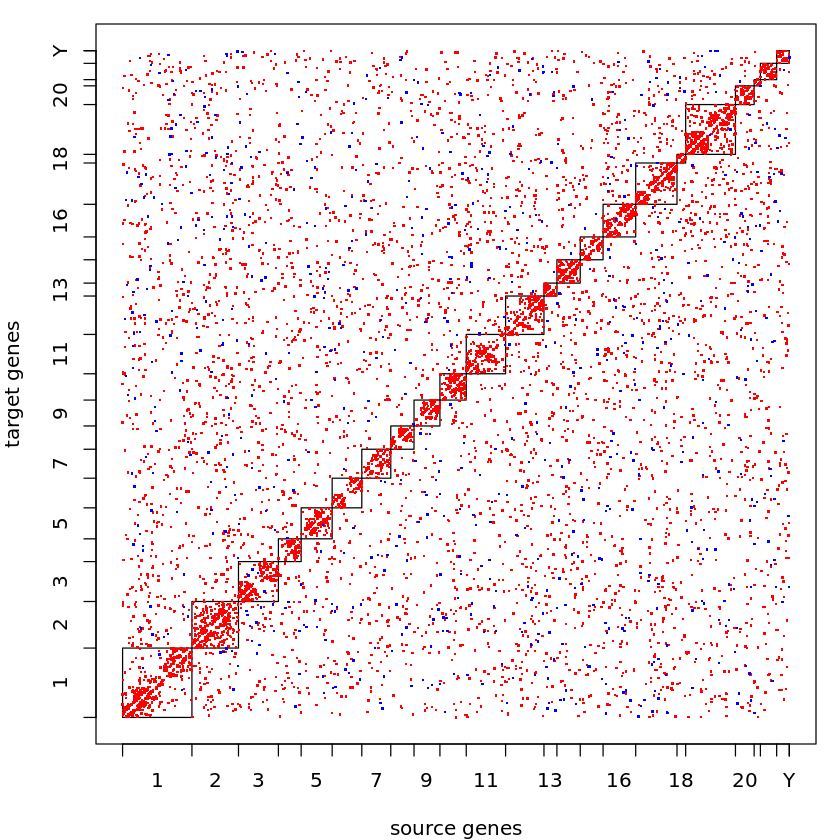

In [112]:
plotInteractions()

In [113]:
png(width = 2400, height = 2400, res = 300, 
    filename = paste0(outDirectory,"/SupplFigure-S6-source-target-interactions.png"))
plotInteractions()
dev.off()

png 
  2

## connectivity table for paper  - SupplTable-S5-connectivity-stats.xls
average out/in links, and genes that appear in >50% of networks

In [121]:
numOfNWs

[1] 2

In [122]:
linkStat3d = array(data=0,dim=c(nrow(conn),6,numOfNWs), 
      dimnames = c(list(conn$Gene),
                   list(c("IncomingRepressorLinks","IncomingActivatorLinks","IncomingLinks","OutgoingRepressorLinks",
                        "OutgoingActivatorLinks","OutgoingLinks")),
                      list(as.character(1:numOfNWs))))

In [123]:
nwIdx = 0
for( f in connectFiles) {
    nwIdx = nwIdx + 1
    conn = read.csv(file = f, header = T,sep = "\t",stringsAsFactors = F)
    rownames(conn) = conn$Gene
    linkStat3d[ conn$Gene,,nwIdx] = as.matrix(conn[,dimnames(linkStat3d)[[2]]])
}

In [124]:
rowMeans(linkStat3d[1:6,1,])

NOC2L   KLHL17     HES4    ISG15     AGRN C1orf159 
     0.5      0.0      0.5      0.5      0.0      0.0

In [125]:
linkStatMeans = sapply(1:dim(linkStat3d)[2], function(i) rowMeans(linkStat3d[,i,]))
colnames(linkStatMeans) = dimnames(linkStat3d)[[2]]

In [126]:
head(linkStatMeans)

,IncomingRepressorLinks,IncomingActivatorLinks,IncomingLinks,OutgoingRepressorLinks,OutgoingActivatorLinks,OutgoingLinks
NOC2L,0.5,4.0,4.5,1.0,7.0,8.0
KLHL17,0.0,2.5,2.5,1.0,5.5,6.5
HES4,0.5,2.5,3.0,0.5,2.5,3.0
ISG15,0.5,6.5,7.0,0.0,9.0,9.0
AGRN,0.0,2.0,2.0,1.0,3.0,4.0
C1orf159,0.0,1.5,1.5,0.0,4.5,4.5


In [127]:
# merge activated and repressed target genes that appear in > 50% of NWs
wh = which(connections$type=="activator")
commonActivatedGenes = sapply( conn$Gene, function(gene) {
    wh2=which(connections$source==gene)
    paste0(connections[ intersect(wh,wh2),"target"],collapse=";")
})
wh = which(connections$type=="repressor")
commonRepressedGenes = sapply( conn$Gene, function(gene) {
    wh2=which(connections$source==gene)
    paste0(connections[ intersect(wh,wh2),"target"],collapse=";")
})

In [128]:
head(connections[ connections$type=="repressor",])

,source,target,type
,<chr>,<chr>,<chr>
7574,KCNAB2,GDF11,repressor
7575,NOL9,RPAIN,repressor
7576,THAP3,SEC23IP,repressor
7577,TMEM201,ERCC5,repressor
7578,PIK3CD,PRKCA,repressor
7579,SRM,WAC,repressor


### add gene annotation

In [130]:
basePath

[1] "/data/bcu_projects/MelBrainSys_PostdocProject_Gruetzmann/publications/2022-my-MelBrainSys-paper/scripts-etc-for-publication/"

In [131]:
currGeneAnnot = geneAnnot
load(paste0(basePath,"annotation/Homo_sapiens.GRCh37.75-chrRename-noHaplo.RData"))
geneAnnotFull = geneAnnot
geneAnnot = currGeneAnnot

In [132]:
geneAnnotFull = geneAnnotFull[ geneAnnotFull$V3=="gene",c("V1","V2","V4","V5","V7","V9")]

In [133]:
colnames(geneAnnotFull) = c("chr","type","start","end","strand","V9")
geneAnnotFull$chr = as.character(geneAnnotFull$chr)
geneAnnotFull$strand = as.character(geneAnnotFull$strand)
geneAnnotFull$type = as.character(geneAnnotFull$type)
geneAnnotFull$V9 = as.character(geneAnnotFull$V9)

In [134]:
geneAnnotFull$EnsemblID = gsub(".*(ENSG[^;]+).*","\\1",geneAnnotFull$V9)
geneAnnotFull$gene = gsub(".*gene_name ([^;]+).*","\\1",geneAnnotFull$V9)

In [135]:
wh = which(duplicated(geneAnnotFull$gene))
length(wh)
geneAnnotFull = geneAnnotFull[-wh,]

[1] 2023

In [136]:
rownames(geneAnnotFull) = geneAnnotFull$gene

In [137]:
head(geneAnnotFull)

,chr,type,start,end,strand,V9,EnsemblID,gene
,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>
DDX11L1,chr1,pseudogene,11869,14412,+,gene_id ENSG00000223972; gene_name DDX11L1; gene_source ensembl_havana; gene_biotype pseudogene;,ENSG00000223972,DDX11L1
WASH7P,chr1,pseudogene,14363,29806,-,gene_id ENSG00000227232; gene_name WASH7P; gene_source ensembl_havana; gene_biotype pseudogene;,ENSG00000227232,WASH7P
MIR1302-10,chr1,lincRNA,29554,31109,+,gene_id ENSG00000243485; gene_name MIR1302-10; gene_source ensembl_havana; gene_biotype lincRNA;,ENSG00000243485,MIR1302-10
FAM138A,chr1,lincRNA,34554,36081,-,gene_id ENSG00000237613; gene_name FAM138A; gene_source ensembl_havana; gene_biotype lincRNA;,ENSG00000237613,FAM138A
OR4G4P,chr1,pseudogene,52473,54936,+,gene_id ENSG00000268020; gene_name OR4G4P; gene_source ensembl_havana; gene_biotype pseudogene;,ENSG00000268020,OR4G4P
OR4G11P,chr1,pseudogene,62948,63887,+,gene_id ENSG00000240361; gene_name OR4G11P; gene_source havana; gene_biotype pseudogene;,ENSG00000240361,OR4G11P


In [138]:
connectStatsOut = data.frame(stringsAsFactors = F, source_gene = conn$Gene, 
                             geneAnnotFull[conn$Gene,c("EnsemblID","chr","type","start","end","strand")],
                             linkStatMeans[,c("OutgoingRepressorLinks","OutgoingActivatorLinks")], 
                            activated_target_genes=commonActivatedGenes, 
                            repressed_target_genes = commonRepressedGenes)
connectStatsOut

,source_gene,EnsemblID,chr,type,start,end,strand,OutgoingRepressorLinks,OutgoingActivatorLinks,activated_target_genes,repressed_target_genes
,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<dbl>,<dbl>,<chr>,<chr>
NOC2L,NOC2L,ENSG00000188976,chr1,protein_coding,879584,894689,-,1.0,7.0,NUDC;DPH2;RRP12;NOL6,
KLHL17,KLHL17,ENSG00000187961,chr1,protein_coding,895967,901095,+,1.0,5.5,RNF207;ATXN7L2,
HES4,HES4,ENSG00000188290,chr1,protein_coding,934342,935552,-,0.5,2.5,RPP25,
ISG15,ISG15,ENSG00000187608,chr1,protein_coding,948803,949920,+,0.0,9.0,IFI6;IFITM1;IRF7;SP110;OGFR,
AGRN,AGRN,ENSG00000188157,chr1,protein_coding,955503,991496,+,1.0,3.0,,
C1orf159,C1orf159,ENSG00000131591,chr1,protein_coding,1017198,1051741,-,0.0,4.5,ULK1;RABEP2;CAPN10,
UBE2J2,UBE2J2,ENSG00000160087,chr1,protein_coding,1189289,1209265,-,0.0,1.5,,
PUSL1,PUSL1,ENSG00000169972,chr1,protein_coding,1243947,1247057,+,1.0,0.5,,
CPSF3L,CPSF3L,ENSG00000127054,chr1,protein_coding,1246965,1260071,-,0.0,2.5,ZBTB48,


In [139]:
# load gene pathway memberships (from circos plot notbook)
geneList = readRDS(file = paste0(basePath,"annotation/gene-pathways-membership-lists.rds"))

In [140]:
names(geneList)
head(geneList$cancerCensus)

[1] "immuneGenes"    "metabolicGenes" "signalingGenes" "cancerCensus"  
[5] "oncogene"       "tumorsuppr"     "TFs"

[1] "SKI"      "TNFRSF14" "PRDM16"   "RPL22"    "CAMTA1"   "MTOR"

In [141]:
genePWannot = data.frame(stringsAsFactors = F,matrix(
    data = "no",nrow = nrow(connectStatsOut), ncol = length(geneList),
    dimnames = c(list(connectStatsOut$source_gene), list(colnames=names(geneList))) ))

In [142]:
for(i in 1:length(geneList)) {
    wh = which(connectStatsOut$source_gene %in% geneList[[i]])
    if(length(wh)>0) {
        genePWannot[wh,i] = "yes"
    }
}

In [143]:
colnames(genePWannot) = c("immune system", "metabolism","signaling pathway","cancer census","oncogene","tumor suppressor","transcription factor")
genePWannot

,immune system,metabolism,signaling pathway,cancer census,oncogene,tumor suppressor,transcription factor
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
NOC2L,no,no,no,no,no,no,no
KLHL17,no,no,no,no,no,no,no
HES4,no,no,no,no,no,no,yes
ISG15,yes,no,no,no,no,no,no
AGRN,no,no,yes,no,no,no,no
C1orf159,no,no,no,no,no,no,no
UBE2J2,no,no,no,no,no,no,no
PUSL1,no,no,no,no,no,no,no
CPSF3L,no,no,no,no,no,no,no


In [144]:
connectStatsOut = cbind(connectStatsOut,genePWannot[connectStatsOut$source_gene,])
connectStatsOut

,source_gene,EnsemblID,chr,type,start,end,strand,OutgoingRepressorLinks,OutgoingActivatorLinks,activated_target_genes,repressed_target_genes,immune system,metabolism,signaling pathway,cancer census,oncogene,tumor suppressor,transcription factor
,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
NOC2L,NOC2L,ENSG00000188976,chr1,protein_coding,879584,894689,-,1.0,7.0,NUDC;DPH2;RRP12;NOL6,,no,no,no,no,no,no,no
KLHL17,KLHL17,ENSG00000187961,chr1,protein_coding,895967,901095,+,1.0,5.5,RNF207;ATXN7L2,,no,no,no,no,no,no,no
HES4,HES4,ENSG00000188290,chr1,protein_coding,934342,935552,-,0.5,2.5,RPP25,,no,no,no,no,no,no,yes
ISG15,ISG15,ENSG00000187608,chr1,protein_coding,948803,949920,+,0.0,9.0,IFI6;IFITM1;IRF7;SP110;OGFR,,yes,no,no,no,no,no,no
AGRN,AGRN,ENSG00000188157,chr1,protein_coding,955503,991496,+,1.0,3.0,,,no,no,yes,no,no,no,no
C1orf159,C1orf159,ENSG00000131591,chr1,protein_coding,1017198,1051741,-,0.0,4.5,ULK1;RABEP2;CAPN10,,no,no,no,no,no,no,no
UBE2J2,UBE2J2,ENSG00000160087,chr1,protein_coding,1189289,1209265,-,0.0,1.5,,,no,no,no,no,no,no,no
PUSL1,PUSL1,ENSG00000169972,chr1,protein_coding,1243947,1247057,+,1.0,0.5,,,no,no,no,no,no,no,no
CPSF3L,CPSF3L,ENSG00000127054,chr1,protein_coding,1246965,1260071,-,0.0,2.5,ZBTB48,,no,no,no,no,no,no,no


In [145]:
write.xlsx(x = connectStatsOut, row.names = F,
           file = paste0(outDirectory,"SupplTable-S5-connectivity-stats.xls"))